<a href="https://colab.research.google.com/github/faranak5171/Deep-Learning-projects/blob/master/Dogs_vs_Cats_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets, models
from torch import nn, optim
import torch.nn.functional as F

import warnings
import matplotlib.pyplot as plt

In [2]:
%%capture
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! cp kaggle.json ~/.kaggle/
! kaggle competitions download dogs-vs-cats
! unzip dogs-vs-cats
! unzip train.zip -d train
! unzip test1.zip -d test

In [3]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomRotation(30),
                                      transforms.RandomHorizontalFlip()])

test_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                                      transforms.CenterCrop(224),
                                      transforms.Resize(255)])

In [4]:
trainset = datasets.ImageFolder('train', transform=train_transform)
testset = datasets.ImageFolder('test', transform=train_transform)

In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32)
testloader = torch.utils.data.DataLoader(testset, batch_size=32)

Text(0.5, 1.0, 'cat')

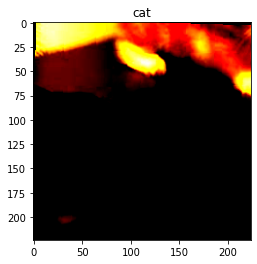

In [6]:
inputs, labels = next(iter(trainloader))
if labels[0]==0:
    title = 'cat'
else:
    title = 'dog'
plt.imshow(torchvision.utils.make_grid(inputs[0]).permute(1,2,0))
plt.title(title)


In [7]:
model = models.densenet121(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

model.classifier = nn.Sequential(nn.Linear(1024,256),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                           nn.Linear(256,2),
                           nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [10]:
%%capture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
epochs = 1
running_loss = 0
steps = 0

for epoch in range(epochs):
  for inputs, labels in trainloader:

    steps += 1

    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    logps = model.forward(inputs)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if steps % 5 == 0:
      test_loss = 0
      accuracy = 0

      for inputs_test, labels_test in testloader:
        model.eval()
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        logps = model.forward(inputs_test)
        loss = criterion(logps, labels_test)

        test_loss += loss.item()
        ps = torch.exp(logps)
        top_k, top_class = ps.topk(1, dim=1)
        equal = top_class == labels_test.view(*top_class.shape)
        accuracy += torch.mean(equal.type(torch.FloatTensor)).item()

      print(f"epochs: {epoch + 1}/{epochs}.. step: {steps} Average Train Loss:{running_loss/5:.3f}.."
            f"Average Test Loss:{test_loss/len(testloader):.3f}.. Accuracy: {accuracy/len(testloader):.3f}..")
      running_loss = 0
      model.train()

epochs: 1/1.. step: 5 Average Train Loss:0.000..Average Test Loss:0.000.. Accuracy: 1.000..
epochs: 1/1.. step: 10 Average Train Loss:0.000..Average Test Loss:0.000.. Accuracy: 1.000..
